# Control arm

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.008976221084594727


3 coordinate transform: 3.499591588973999
2 read results: 4.894899129867554
1 total mesh and result loading: 5.080378770828247
1 total edge processing: 0.40990519523620605


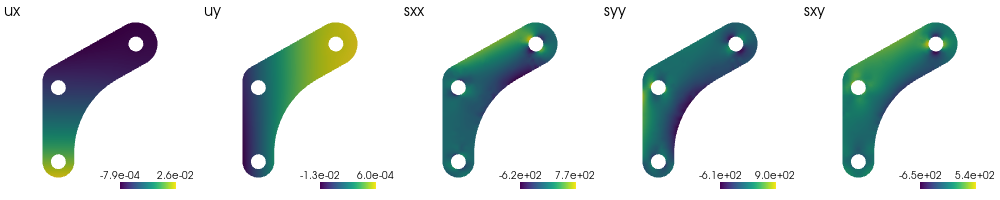

In [2]:
# load mesh and solver results
op2File = 'data/controlArm/v2.0/controlArm02.op2'
geom = MeshGeom(op2File, thickness=1.0)

# flip normals on inner edges so that they point inwards
geom.bndNormsDict[1] *= -1
geom.bndNormsDict[2] *= -1
geom.bndNormsDict[3] *= -1

plotScalarFields(geom.mesh, geom.resDf)

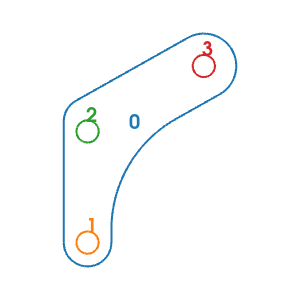

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.056846 s

'compile' took 1.263613 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [5.33e+02, 5.66e+02, 1.06e+06, 2.29e+05, 1.72e+04, 4.11e-06, 4.29e-08, 1.41e+02, 1.59e+02, 5.00e+03, 3.91e+02, 4.87e+03, 3.78e+00]    [5.40e+02, 6.02e+02, 1.11e+06, 2.34e+05, 1.71e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 1.32e+06
  test loss: 1.36e+06
  test metric: []

'train' took 0.532538 s

Compiling model...
'compile' took 1.025254 s

Initializing variables...
Training model...

Step      Train loss                                                

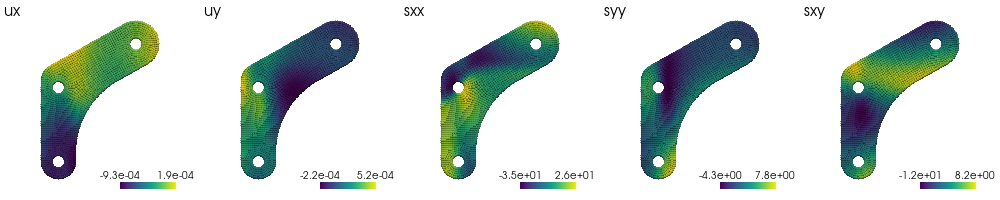

In [12]:
# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
bndNumSamplesDir = {0:800, 1:200, 2:200, 3:200}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 
lw[9] *= 100
lw[11] *= 100
lw[12] *= 10

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

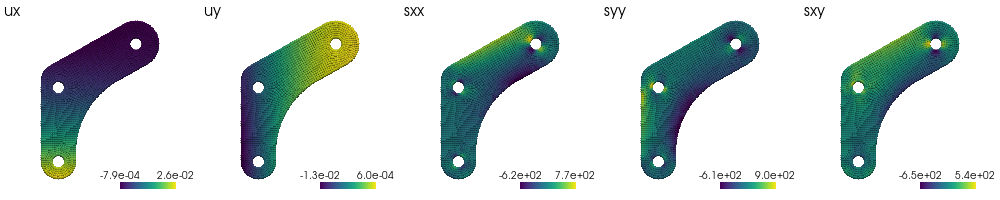

In [5]:
plotScalarFields(pc, geom.resDf)

In [13]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

Compiling model...
'compile' took 0.733060 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
1000      [2.61e+01, 2.04e-01, 3.09e-02, 3.08e-02, 1.42e-01, 3.57e-04, 1.25e-02, 1.06e+00, 1.04e-01, 7.21e+01, 1.40e-02, 5.40e+01, 2.57e-01]    [1.37e+01, 1.96e-01, 3.29e-02, 3.58e-02, 1.88e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1100      [2.57e+01, 2.45e-01, 3.01e-02, 3.91e-02, 1.60e-01, 1.87e-04, 3.24e-03, 1.03e+00, 1.11e-01, 7.17e+01, 9.27e-03, 5.22e+01, 2.79e-01]    [1.22e+01, 2.22e-01, 3.18e-02, 4.65e-02, 2.07e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1200      [2.61e+01, 3.54e-01, 3.52e-02, 5.81e-02, 2.35e-01, 1.46e-04, 7.05e-03

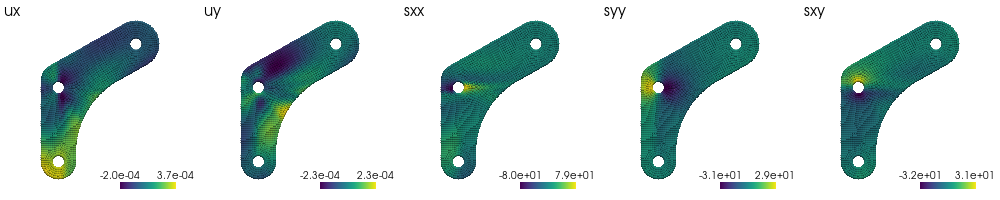

In [14]:
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [15]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

Compiling model...
'compile' took 0.937511 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
2000      [1.44e+01, 5.42e-01, 3.03e-02, 1.32e-01, 5.70e-02, 5.38e-05, 6.26e-04, 9.39e-01, 9.72e-02, 6.62e+01, 9.39e-03, 1.40e+01, 7.93e+00]    [1.07e+01, 3.87e-01, 3.45e-02, 9.61e-02, 7.27e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2100      [1.44e+01, 5.50e-01, 2.93e-02, 1.25e-01, 5.71e-02, 4.00e-05, 2.51e-04, 9.48e-01, 8.77e-02, 6.61e+01, 8.68e-03, 1.42e+01, 7.65e+00]    [1.07e+01, 3.79e-01, 3.38e-02, 9.10e-02, 6.99e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2200      [1.44e+01, 5.32e-01, 3.08e-02, 1.18e-01, 5.82e-02, 4.13e-05, 2.16e-04

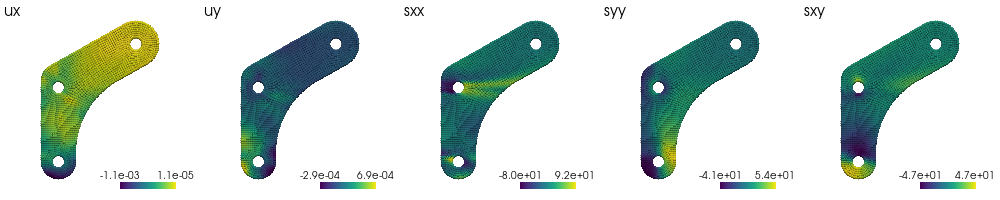

In [16]:
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=3000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

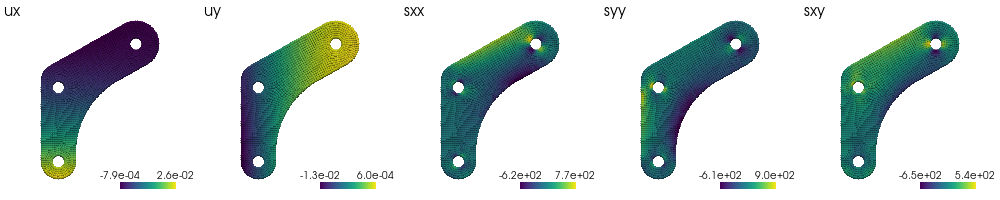

In [18]:
plotScalarFields(pc, geom.resDf)

In [17]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

Compiling model...
'compile' took 0.758968 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
5000      [9.08e+00, 1.89e+00, 2.60e-02, 1.99e-01, 1.51e-01, 9.30e-06, 3.02e-04, 2.10e+00, 9.33e-01, 1.21e+01, 2.07e-01, 6.84e+00, 5.94e+00]    [7.50e+00, 1.54e+00, 2.11e-02, 1.53e-01, 1.50e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
5100      [6.34e+00, 2.42e+00, 7.69e-02, 2.48e-01, 3.16e-01, 1.08e-03, 3.18e-04, 3.19e+00, 9.27e-01, 3.17e+00, 4.18e-01, 5.31e+00, 5.64e+00]                                                                                                                                              
5200      [3.15e+00, 1.89e+00, 9.78e-02, 1.85e-01, 2.94e-01, 1.34e-03, 1.11e-04

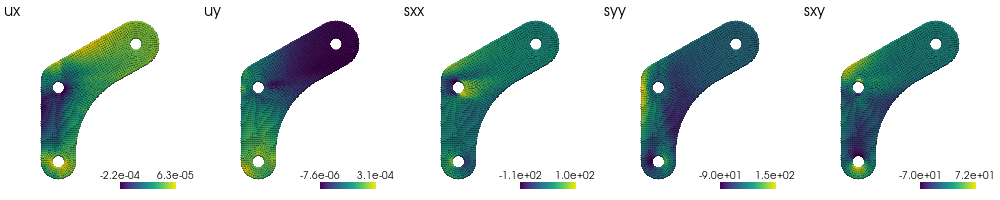

In [20]:
model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=2000
model.train_op.optimizer_kwargs['options']['maxfun']=2000
losshistory, train_state = model.train(display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [21]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

Compiling model...
'compile' took 0.877685 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
7001      [4.50e-01, 2.94e-01, 8.85e-03, 1.97e-02, 2.20e-02, 1.78e-05, 6.48e-05, 1.25e+00, 3.71e-01, 4.02e-02, 7.00e-02, 9.09e-01, 2.49e+00]    [1.11e+00, 8.49e-01, 9.84e-03, 1.97e-02, 2.68e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
7100      [4.30e-01, 2.69e-01, 6.05e-03, 1.49e-02, 1.77e-02, 2.47e-05, 2.22e-04, 1.25e+00, 3.71e-01, 3.50e-02, 6.57e-02, 8.88e-01, 2.49e+00]                                                                                                                                              
7200      [4.09e-01, 2.54e-01, 7.57e-03, 1.24e-02, 1.52e-02, 2.59e-06, 3.52e-05

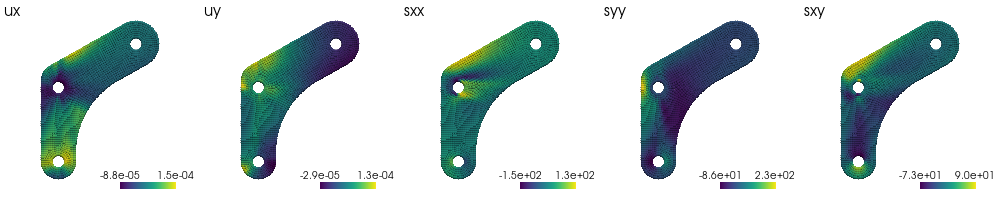

In [22]:
model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=2000
model.train_op.optimizer_kwargs['options']['maxfun']=2000
losshistory, train_state = model.train(display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [23]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

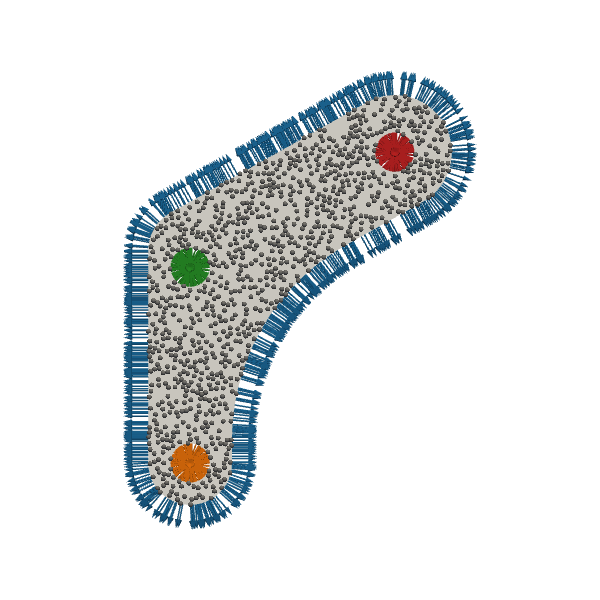

In [19]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');